In [72]:
import tensorflow as tf
from tensorflow.python.client import timeline
import pylab
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tf.logging.set_verbosity(tf.logging.INFO)

In [73]:
tf.reset_default_graph()

In [74]:
num_samples = 100000

In [75]:
from datetime import datetime 

version = int(datetime.now().strftime("%s"))

[  3.83112848e-01   3.05098176e-01   4.58981007e-01 ...,   6.86228693e-01
   2.60688484e-01   5.00827970e-04]
[ 0.35502015  0.32367502  0.33682059 ...,  0.36082014  0.32017043
  0.28699132]


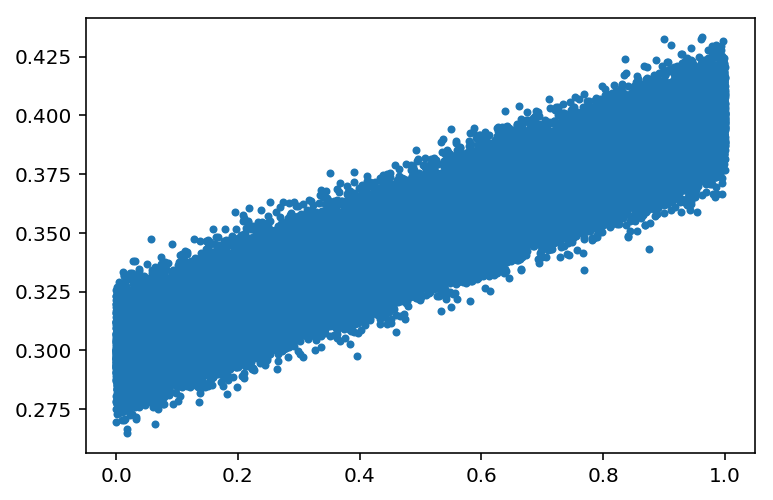

In [76]:
# 1.2 Create input data using NumPy. y = x * 0.1 + 0.3 + noise
x_train = np.random.rand(num_samples).astype(np.float32)
print(x_train)

noise = np.random.normal(scale=0.01, size=len(x_train))

y_train = x_train * 0.1 + 0.3 + noise
print(y_train)

# Pplot our input data.
pylab.plot(x_train, y_train, '.')

[ 0.05496995  0.28317869  0.71917582 ...,  0.08036009  0.77551216
  0.55914831]
[ 0.3132326   0.33189043  0.37616863 ...,  0.29645792  0.37451432
  0.36763763]


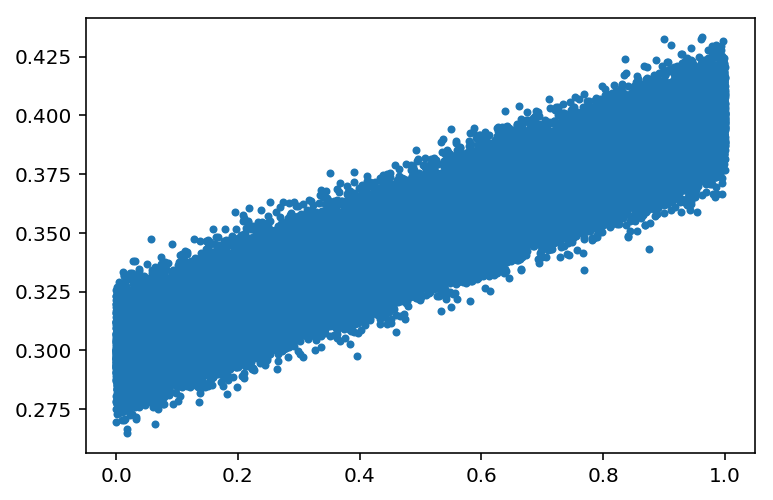

In [77]:
# Create some fake test/validation data
x_test = np.random.rand(len(x_train)).astype(np.float32)
print(x_test)

noise = np.random.normal(scale=.01, size=len(x_train))

y_test = x_test * 0.1 + 0.3 + noise
print(y_test)

pylab.plot(x_train, y_train, '.')

In [78]:
# 1.3 Build inference graph.
# Create Variables W and b that compute y = W * x + b
with tf.device("/cpu:0"):
  W = tf.get_variable(shape=[], name='weights')
  print(W)

  b = tf.get_variable(shape=[], name='bias')
  print(b)

  # Create a placeholder we'll use later to feed x's into the graph for training and test.
  # shape=[None] means we can put in any number of examples. 
  # This is used for minibatch training, and to evaluate a lot of examples at once.
  x_observed = tf.placeholder(shape=[None], dtype=tf.float32, name='x_observed')
  print(x_observed)

with tf.device("/gpu:0"):
#  with jit_scope():
    # Same as tf.add(tf.matmul(W, tf.transpose(x)), b)
    y_pred = W * x_observed + b
    print(y_pred)

<tf.Variable 'weights:0' shape=() dtype=float32_ref>
<tf.Variable 'bias:0' shape=() dtype=float32_ref>
Tensor("x_observed:0", shape=(?,), dtype=float32, device=/device:CPU:0)
Tensor("add:0", shape=(?,), dtype=float32, device=/device:GPU:0)


In [79]:
# 1.4 Build training graph.
# Create an operation that calculates loss.

# Create a placeholder we'll use later to feed the correct y value into the graph
with tf.device("/gpu:0"):
#  with jit_scope():
    y_observed = tf.placeholder(shape=[None], dtype=tf.float32, name='y_observed')
    print(y_observed)

    loss_op = tf.reduce_mean(tf.square(y_pred - y_observed))

    # Create an optimizer.
    optimizer_op = tf.train.GradientDescentOptimizer(0.025)  

    # Create an operation that minimizes loss.
    train_op = optimizer_op.minimize(loss_op)  

    # 'loss', 'optimizer' and 'train' are.
    print("loss:", loss_op)
    print("optimizer:", optimizer_op)
    print("train:", train_op)

Tensor("y_observed:0", shape=(?,), dtype=float32, device=/device:GPU:0)
loss: Tensor("Mean:0", shape=(), dtype=float32, device=/device:GPU:0)
optimizer: <tensorflow.python.training.gradient_descent.GradientDescentOptimizer object at 0x7f02a053a198>
train: name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_weights/ApplyGradientDescent"
input: "^GradientDescent/update_bias/ApplyGradientDescent"
device: "/device:CPU:0"



In [80]:
# Create an operation to initialize all the variables.
with tf.device("/cpu:0"):
  init_op = tf.global_variables_initializer()
  print(init_op)

name: "init"
op: "NoOp"
input: "^weights/Assign"
input: "^bias/Assign"
device: "/device:CPU:0"



In [81]:
train_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/gpu/%s/train' % version, graph=tf.get_default_graph())

test_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/gpu/%s/test' % version, graph=tf.get_default_graph())

In [82]:
config = tf.ConfigProto(
  log_device_placement=True,
)
config.gpu_options.allow_growth=True
print(config)

sess = tf.Session(config=config)
print(sess)


gpu_options {
  allow_growth: true
}
log_device_placement: true



In [83]:
sess.run(init_op)
print(sess.run(W))
print(sess.run(b))

0.420015
0.454122


## Accuracy of Random Weights

In [84]:
# Convenience method for evaluating the loss (error)
def test(x, y):
  return sess.run(loss_op, feed_dict={x_observed: x, y_observed: y})

In [85]:
# Calculate accuracy on the test data using random initial values for y
# Note:  This should be relatively far from 0 since we haven't yet trained the model
test(x=x_test, y=y_test)

0.10731471

In [86]:
# Add a Summary Operation so we can visualize the loss in TensorBoard
loss_summary_scalar_op = tf.summary.scalar('loss', loss_op)
loss_summary_merge_all_op = tf.summary.merge_all()

# Train Model

In [87]:
%%time

max_steps = 350

run_metadata = tf.RunMetadata()

for step in range(max_steps):
  # Run the training op; feed the training data into the graph
  if (step < max_steps):
    test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
    train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train})
  else:  
    test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
    train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train}, options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE), run_metadata=run_metadata)
    trace = timeline.Timeline(step_stats=run_metadata.step_stats)    
    with open('gpu-timeline.json', 'w') as trace_file:
      trace_file.write(trace.generate_chrome_trace_format(show_memory=True))

# The following take a relatively long time, so do them at periodic intervals
  if step % 5 == 0:
    print(step, sess.run([W, b]))
    train_summary_writer.add_summary(train_summary_log, step)
    train_summary_writer.flush()
    test_summary_writer.add_summary(test_summary_log, step)
    test_summary_writer.flush()

0 [0.41082379, 0.43841013]
5 [0.37240416, 0.37385392]
10 [0.34392843, 0.32774812]
15 [0.32263222, 0.29493305]
20 [0.306523, 0.27169004]
25 [0.29416448, 0.25533921]
30 [0.28452128, 0.24394913]
35 [0.27684706, 0.23612797]
40 [0.27060375, 0.23087269]
45 [0.26540321, 0.22746046]
50 [0.26096568, 0.22537044]
55 [0.25708923, 0.22422737]
60 [0.25362819, 0.22376087]
65 [0.2504774, 0.22377618]
70 [0.24756087, 0.22413301]
75 [0.24482369, 0.22473037]
80 [0.24222611, 0.22549558]
85 [0.23973927, 0.2263763]
90 [0.23734225, 0.22733489]
95 [0.23501982, 0.22834437]
100 [0.23276077, 0.22938533]
105 [0.23055695, 0.23044388]
110 [0.2284023, 0.2315101]
115 [0.22629225, 0.23257692]
120 [0.22422345, 0.23363933]
125 [0.22219329, 0.23469378]
130 [0.22019972, 0.23573779]
135 [0.21824116, 0.23676966]
140 [0.21631628, 0.23778826]
145 [0.21442407, 0.23879279]
150 [0.21256357, 0.23978283]
155 [0.21073404, 0.24075803]
160 [0.20893475, 0.24171834]
165 [0.20716508, 0.24266374]
170 [0.20542446, 0.24359424]
175 [0.203712

(0, 1.0)

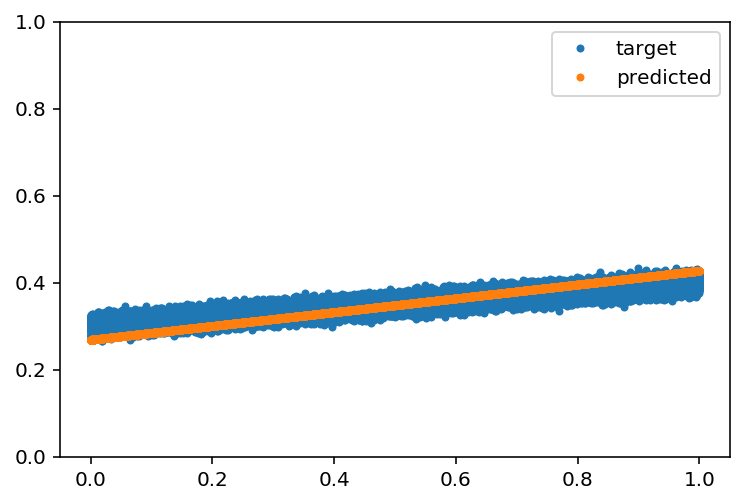

In [88]:
# Plot the predicted values
pylab.plot(x_train, y_train, '.', label="target")
pylab.plot(x_train, sess.run(y_pred, feed_dict={x_observed: x_train, y_observed: y_train}), ".", label="predicted")
pylab.legend()
pylab.ylim(0, 1.0)

In [89]:
# Check accuracy on eval data after training
# Note:  This should be close to 0!
test(x=x_test, y=y_test)

0.00039180784

In [90]:
export_path = "/root/models/linear/gpu/%s" % version
print(export_path)

/root/models/linear/gpu/1490931609


In [91]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants

with tf.device("/cpu:0"):
  builder = saved_model_builder.SavedModelBuilder(export_path)

prediction_signature =  signature_def_utils.build_signature_def(
    inputs = {'x_observed': tensor_info_x_observed}, 
    outputs = {'y_pred': tensor_info_y_pred}, 
    method_name = signature_constants.PREDICT_METHOD_NAME)            

legacy_init_op = tf.group(tf.initialize_all_tables(), name='legacy_init_op')

builder.add_meta_graph_and_variables(sess, 
  [tag_constants.SERVING],
  signature_def_map={'predict':prediction_signature,
  signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:prediction_signature}, 
  legacy_init_op=legacy_init_op)

builder.save()

Instructions for updating:
Use `tf.tables_initializer` instead.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'/root/models/linear/gpu/1490931609/saved_model.pb'


b'/root/models/linear/gpu/1490931609/saved_model.pb'

## Save the Model in Previous Format
We will use this later.

In [ ]:
from tensorflow.python.framework import graph_io
graph_io.write_graph(sess.graph, "/root/models/optimize_me/", "unoptimized_gpu.pb")

## Look at the Model In Tensorboard

http://[ip-address]:6006